In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
from jax import random
import pandas as pd
import matplotlib.pyplot as plt

from src.dt_vnc_rnn import create_random_network, InputFunction
from src.vnc_sim import run_single_simulation

# Setup simulation params
- simulation tie parameters
- recurrent weight matrix -> based on stored pre-processed data
- random keys for JAX reproducibility
- DN stimulation strength

In [3]:
######################################################
### SIMULATION PARAMETERS ############################
simulation_time = 2  # seconds
dt = 0.00001  # seconds
pulse_start = 0.05
num_timesteps = int(simulation_time / dt)
num_simulations = 1
r_tol = 1e-5
a_tol = 1e-5

######################################################
### WEIGHTS ##########################################
# load data
weights_pd = pd.read_csv("../../../data/manc t1 connectome data/W_20231020_DNtoMN_unsorted.csv")
neuron_properties = pd.read_csv(
    "../../../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv", index_col=0
)
# extract weights
weights = weights_pd.drop(columns="bodyId_pre").to_numpy().astype(float).T  # transpose to have shape (n_post, n_pre)
assert weights.shape[0] == weights.shape[1], "Weights matrix must be square"

# get number of neurons
num_neurons = weights.shape[0]

# get indices for MNs and Minicircuit neurons
mn_indices = jnp.where((neuron_properties["class"] == "motor neuron").to_numpy())[0]
mini_circuit_body_IDs = [10093, 10707, 11751, 13905]
minicircuit_indices = jnp.where((neuron_properties["bodyId"].isin(mini_circuit_body_IDs)).to_numpy())[0]


######################################################
### RANDOM KEYS ######################################
seed = 11

######################################################
### STIMULUS STRENGTH ################################
stimulus_strength = 250

# Discrete RNN

### Create stimulus

In [4]:
stimulus = jnp.zeros(num_neurons)
stimulus = stimulus.at[jnp.where((neuron_properties["bodyId"] == 10093).to_numpy())[0][0]].set(
    1.0  # stimulate neuron 10093 - DNg100 / BDN2 / DNxl058
)
stimulus *= stimulus_strength

### Setup Input and Noise Functions that drive the VNC-RNN

In [5]:
inputF = InputFunction(
    input_type="step",
    num_neurons=num_neurons,
    num_timesteps=num_timesteps,
    dt=dt,
    batch_size=num_simulations,
    store_full=True,
    amplitude_before=0,
    amplitude_after=stimulus,
    step_time=pulse_start,
)

### Setup the VNC-RNN

In [6]:
vncRnn = create_random_network(
    num_neurons=num_neurons,
    dt=dt,
    weights=weights,
    activation_function="scaled_tanh_relu",
    gains_stats={
        "distribution": "normal",
        "mean": 1.0,
        "std": 0.2,
    },
    max_firing_rates_stats={
        "distribution": "normal",
        "mean": 200.0,
        "std": 15.0,
    },
    thresholds_stats={
        "distribution": "normal",
        "mean": 4.0,
        "std": 0.5,
    },
    time_constants_stats={
        "distribution": "normal",
        "mean": 20e-3,
        "std": 2.5e-3,
    },
    neuron_sizes=neuron_properties["size"].values,
    random_seed=seed,
)

#### Qualitatively check distribution of random parameters

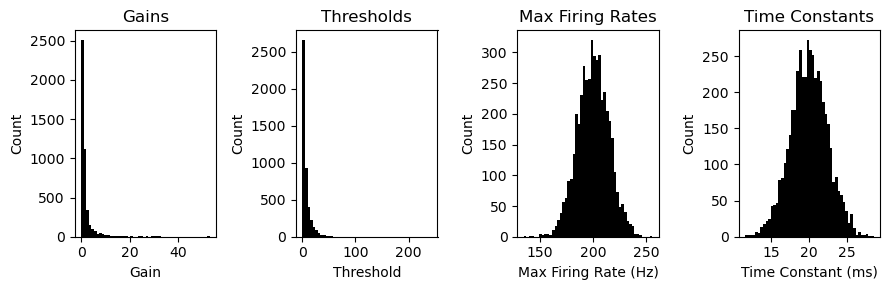

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(9, 3))
axes[0].hist(vncRnn.gains, bins=50, color="k")
axes[0].set_title("Gains")
axes[0].set_xlabel("Gain")
axes[0].set_ylabel("Count")
axes[1].hist(vncRnn.thresholds, bins=50, color="k")
axes[1].set_title("Thresholds")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Count")
axes[2].hist(vncRnn.max_firing_rates, bins=50, color="k")
axes[2].set_title("Max Firing Rates")
axes[2].set_xlabel("Max Firing Rate (Hz)")
axes[2].set_ylabel("Count")
axes[3].hist(vncRnn.time_constants * 1e3, bins=50, color="k")
axes[3].set_title("Time Constants")
axes[3].set_xlabel("Time Constant (ms)")
axes[3].set_ylabel("Count")
plt.tight_layout()
plt.show()

## Simulate ODE RNN
- setup with the same simulation parameters as the Discrete simulation

In [8]:
multiplicative_factor_dt = int((1e-3+1e-15) // dt)
print(multiplicative_factor_dt)
dt_ODE = dt * multiplicative_factor_dt
num_timesteps_ODE = int(simulation_time / dt_ODE)

inputs_ODE = jnp.zeros(len(weights))
inputs_ODE = inputs_ODE.at[jnp.where((neuron_properties["bodyId"] == 10093).to_numpy())[0][0]].set(stimulus_strength)

firing_rates_ODE = run_single_simulation(
    W=vncRnn.weights * vncRnn.relative_inputs_scale,
    tau=vncRnn.time_constants,
    a=vncRnn.gains,
    threshold=vncRnn.thresholds,
    fr_cap=vncRnn.max_firing_rates,
    inputs=inputs_ODE,
    noise_stdv=0,
    t_axis=jnp.arange(1, num_timesteps_ODE) * dt_ODE,
    T=simulation_time,
    dt=dt,
    pulse_start=pulse_start,
    pulse_end=simulation_time,
    r_tol=r_tol,
    a_tol=a_tol,
    key=random.key(seed),
)

100


In [9]:
firing_rates_ODE.shape  # should be (num_neurons, num_timesteps)

(4561, 1999)

## Simulate Discrete RNN

In [10]:
firing_rates_Discrete = vncRnn.simulate(
    num_timesteps=num_timesteps,
    input_func=inputF,
    input_noise_std=0,  # 0.21,
    recurrent_noise_std=0,  # 0.21,
    input_noise_tau=1.0,
    recurrent_noise_tau=1.0,
    initial_state=None,
    batch_size=inputF.batch_size,
    random_seed=seed + 1,
)

In [11]:
firing_rates_Discrete.shape  # should be (num_timesteps, batch_size, num_neurons)

(200000, 1, 4561)

# Visually compare results

In [12]:
# convert to numpy for plotting
plot_every_N_steps = multiplicative_factor_dt
mn_firing_rates_Discrete = np.asarray(firing_rates_Discrete)[::plot_every_N_steps, :, mn_indices]
minicircuit_firing_rates_Discrete = np.asarray(firing_rates_Discrete)[::plot_every_N_steps, :, minicircuit_indices]
mn_firing_rates_ODE = np.asarray(firing_rates_ODE)[mn_indices]
minicircuit_firing_rates_ODE = np.asarray(firing_rates_ODE)[minicircuit_indices]

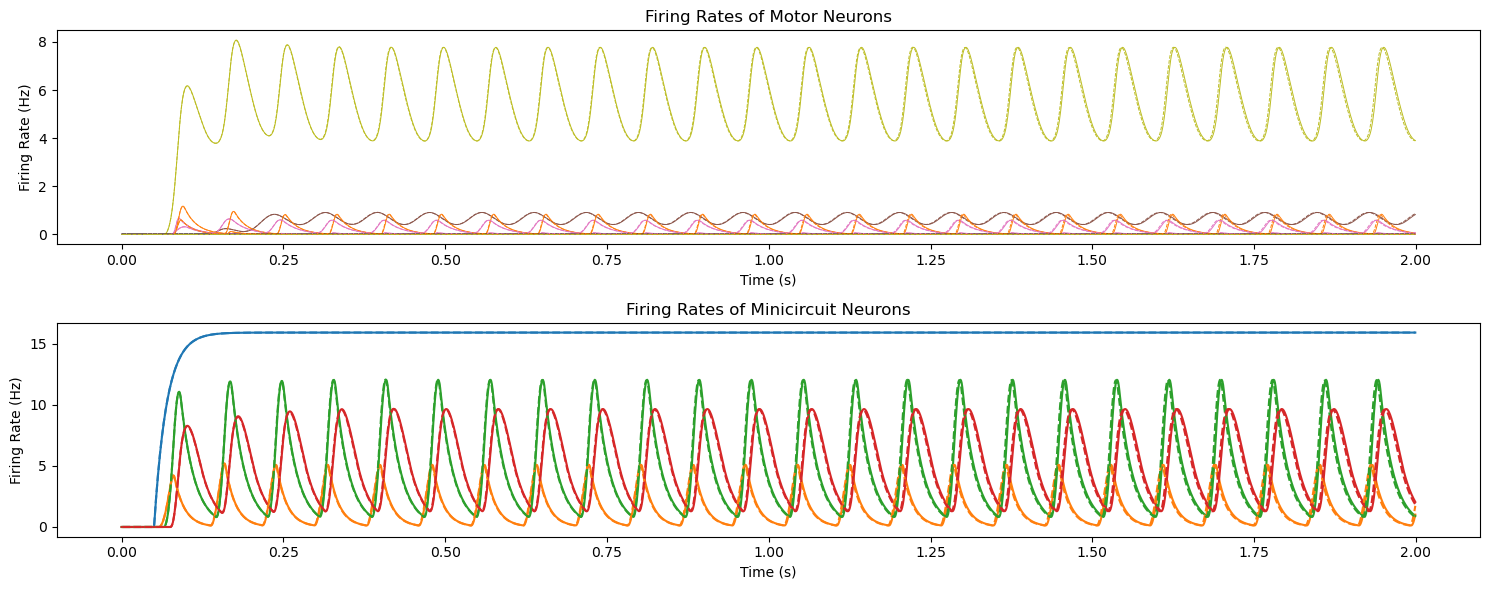

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
axes[0].plot(np.arange(0, num_timesteps + 1, plot_every_N_steps) * dt, mn_firing_rates_Discrete[:, 0, :], lw=0.7)
axes[0].set_prop_cycle(None)  # reset color cycle
axes[0].plot(np.arange(1, num_timesteps_ODE) * dt_ODE, mn_firing_rates_ODE.T, lw=0.7, ls="--")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Firing Rate (Hz)")
axes[0].set_title("Firing Rates of Motor Neurons")

axes[1].plot(np.arange(0, num_timesteps + 1, plot_every_N_steps) * dt, minicircuit_firing_rates_Discrete[:, 0, :])
axes[1].set_prop_cycle(None)  # reset color cycle
axes[1].plot(np.arange(1, num_timesteps_ODE) * dt_ODE, minicircuit_firing_rates_ODE.T, ls="--")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Firing Rate (Hz)")
axes[1].set_title("Firing Rates of Minicircuit Neurons")

plt.tight_layout()
plt.show()